 # **Proyek Akhir : Membuat Model Sistem Rekomendasi**

 - Nama : Dimas Aditia Anugerah Setiady
 - Email : mc240d5y0910@student.devacademy.id
 - ID Dicoding : MC240D5Y0910

### **Import Library**
Pada tahap ini, berbagai library Python yang diperlukan untuk analisis data dan machine learning akan diimpor. Library ini akan digunakan dalam seluruh proses eksplorasi, persiapan, pelatihan, dan evaluasi model.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.simplefilter('ignore')

## **Data Understanding**
Data Understanding merupakan tahap awal yang krusial dalam pengembangan proyek machine learning maupun data science. Tahap ini bertujuan untuk memahami isi, struktur, serta kualitas data yang akan dianalisis. Dalam proyek ini, proses Data Understanding akan dilakukan melalui tiga tahapan utama, yaitu:
- Melakukan load dataset 
- Melakukan univariate exploratory data analysis (EDA)
- Melakukan visualisasi data



In [2]:
# Load dataset
df = pd.read_csv(r'C:\Users\ADVAN\Documents\The Movies Dataset\movies_metadata.csv')

In [3]:
# Cek 5 baris pertama dataset
print(df.head())


   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

#### **Univariate Exploratory Data Analysis**

**Cek Informasi Dataset (struktur dan tipe data)**

In [4]:
# Melihat info dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [5]:
# Statistik deskriptif untuk kolom numerik
print(df[['vote_average', 'vote_count']].describe())

       vote_average    vote_count
count  45460.000000  45460.000000
mean       5.618207    109.897338
std        1.924216    491.310374
min        0.000000      0.000000
25%        5.000000      3.000000
50%        6.000000     10.000000
75%        6.800000     34.000000
max       10.000000  14075.000000


In [6]:
# Cek missing value
print(df[['title', 'genres', 'overview', 'vote_average']].isnull().sum())


title             6
genres            0
overview        954
vote_average      6
dtype: int64


#### **Visualisasi Univariate**

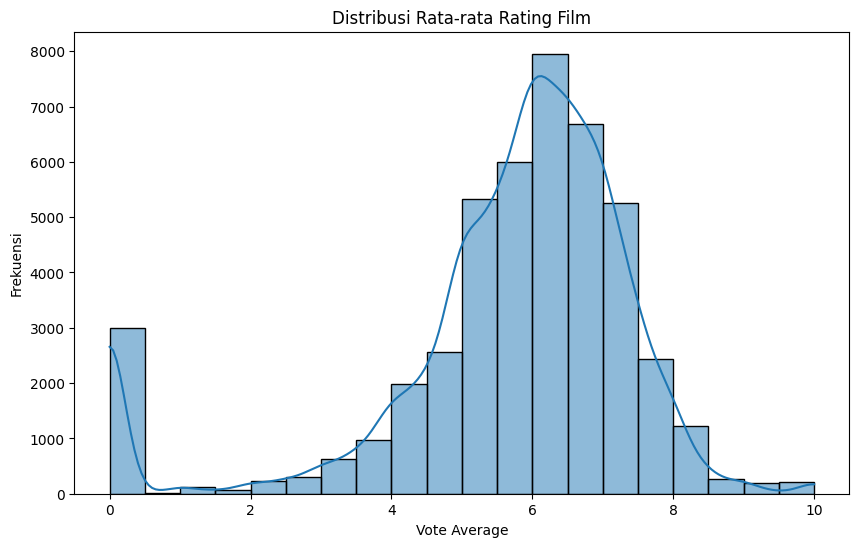

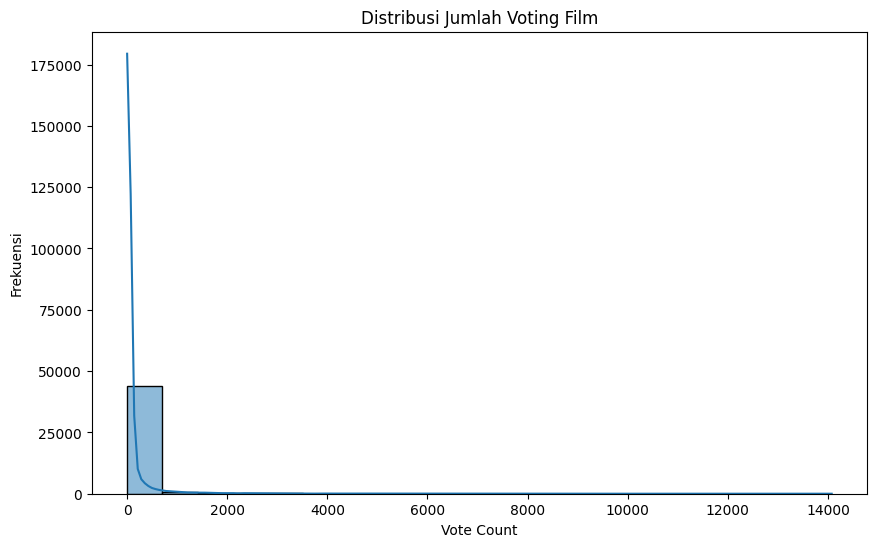

In [7]:
# Distribusi vote_average
plt.figure(figsize=(10, 6))
sns.histplot(df['vote_average'], bins=20, kde=True)
plt.title('Distribusi Rata-rata Rating Film')
plt.xlabel('Vote Average')
plt.ylabel('Frekuensi')
plt.show()

# Distribusi vote_count
plt.figure(figsize=(10, 6))
sns.histplot(df['vote_count'], bins=20, kde=True)
plt.title('Distribusi Jumlah Voting Film')
plt.xlabel('Vote Count')
plt.ylabel('Frekuensi')
plt.show()

## **Data Preparation**

In [8]:
# 1. Cek missing value
print(df.isnull().sum())

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64


In [9]:
# 2. Tangani missing value
df['overview'] = df['overview'].fillna('')
df['genres'] = df['genres'].fillna('')
df['title'] = df['title'].fillna('')

*Insight :*
- Missing value telah berhasil ditangani.

In [10]:
# 3. Cek data duplikat
duplicates = df.duplicated()
print(f"Jumlah duplikat: {duplicates.sum()}")

Jumlah duplikat: 13


In [11]:
# 4. Hapus data duplikat
df = df.drop_duplicates().reset_index(drop=True)

# Cek ulang jumlah duplikat
print(f"Jumlah duplikat setelah dibersihkan: {df.duplicated().sum()}")


Jumlah duplikat setelah dibersihkan: 0


*Insight :*
- Data duplikat telah berhasil ditangani.

In [12]:
# 5. Parsing kolom genres
def parse_genres(genres_str):
    try:
        genres = json.loads(genres_str.replace("'", "\""))
        return ' '.join([genre['name'] for genre in genres])
    except:
        return ''

df['genres'] = df['genres'].apply(parse_genres)


In [13]:
# 6. Buat fitur gabungan (genres + overview)
df['combined_features'] = df['genres'] + ' ' + df['overview']

In [14]:
# 7. Filter film dengan vote_count > 50 untuk memastikan kualitas
df = df[df['vote_count'] > 50].reset_index(drop=True)

# 8. Cek hasil preprocessing
print(df[['title', 'combined_features']].head())

                         title  \
0                    Toy Story   
1                      Jumanji   
2             Grumpier Old Men   
3  Father of the Bride Part II   
4                         Heat   

                                   combined_features  
0  Animation Comedy Family Led by Woody, Andy's t...  
1  Adventure Fantasy Family When siblings Judy an...  
2  Romance Comedy A family wedding reignites the ...  
3  Comedy Just when George Banks has recovered fr...  
4  Action Crime Drama Thriller Obsessive master t...  


## **Modeling & Evaluasi**

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Ekstraksi fitur dengan TF-IDF
try:
    tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
    tfidf_matrix = tfidf.fit_transform(df['combined_features'])
except Exception as e:
    print(f"Error saat membuat matriks TF-IDF: {e}")
    exit()

# Hitung Cosine Similarity
try:
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    print("Matriks Cosine Similarity berhasil dibuat!")
except Exception as e:
    print(f"Error saat menghitung Cosine Similarity: {e}")
    exit()
    
# Fungsi aman untuk mendapatkan rekomendasi
def get_recommendations(title, cosine_sim=cosine_sim, df=df, top_k=10):
    matches = df[df['title'].str.lower() == title.lower()]
    
    if matches.empty:
        return f"Judul '{title}' tidak ditemukan di dataset."

    idx = matches.index[0]
    
    if idx >= cosine_sim.shape[0]:
        return f"Index {idx} lebih besar dari ukuran cosine_sim: {cosine_sim.shape[0]}"

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_k+1]
    movie_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[movie_indices].reset_index(drop=True)


Matriks Cosine Similarity berhasil dibuat!


*Insight :*
- Fitur teks diekstraksi menggunakan TfidfVectorizer untuk mengubah teks menjadi representasi numerik

In [16]:
# Coba kita gunakan
print(get_recommendations('The Dark Knight'))


0                      The Dark Knight Rises
1                             Batman Returns
2                 Batman: Under the Red Hood
3                             Batman Forever
4    Batman: The Dark Knight Returns, Part 2
5    Batman: The Dark Knight Returns, Part 1
6                           Batman: Year One
7               Batman: Mask of the Phantasm
8                                   Ricochet
9                   Batman: The Killing Joke
Name: title, dtype: object


In [ ]:
# Evaluasi
test_movies = ['The Dark Knight', 'Toy Story', 'Inception']
for movie in test_movies:
    print(f"Rekomendasi untuk {movie}:")
    print(get_recommendations(movie))

Rekomendasi untuk The Dark Knight:
0                      The Dark Knight Rises
1                             Batman Returns
2                 Batman: Under the Red Hood
3                             Batman Forever
4    Batman: The Dark Knight Returns, Part 2
5    Batman: The Dark Knight Returns, Part 1
6                           Batman: Year One
7               Batman: Mask of the Phantasm
8                                   Ricochet
9                   Batman: The Killing Joke
Name: title, dtype: object
Rekomendasi untuk Toy Story:
0               Toy Story 3
1               Toy Story 2
2                 Small Fry
3    The 40 Year Old Virgin
4           Man on the Moon
5     Rebel Without a Cause
6             Class of 1984
7              Factory Girl
8                    Malice
9              Burke & Hare
Name: title, dtype: object
Rekomendasi untuk Inception:
0                                 Cypher
1     Mission: Impossible - Rogue Nation
2    Transformers: Revenge of the Fallen
